# Assessing auto-differentiation speed improvement

This notebook aims to have a feeling on the speedup that can be brought by replacing classical gradient descent algorithms used in `SLITronomy` by an auto-differentiation scheme.

We wish to assess the feasability and usefulness of rewriting the loss function designed for the SLIT algorithm in a `TensorFlow` formalism, through a simple test case and timing of function evaluations.

In [1]:
__author__ = 'aymgal', 'austinpeel'
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

# =========

# type of lensing operator
lensing_operator = 'interpol'  # 'interpol' or 'simple'

# number of times to subdivide source plane grid
subgrid_res_source = 2

# starlets scales
n_scales_source = 6
n_scales_lens_light = 6

# compute and reduce source plane to minimal size
minimal_source_plane = False

# use the image mask computed through noise threshold
use_threshold_mask = False

# =========

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41) (83, 83)


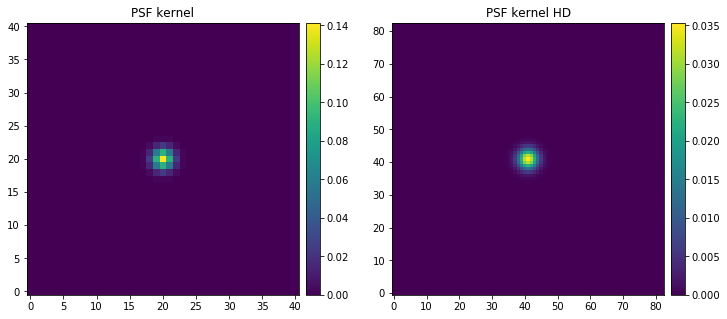

In [5]:
# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
psf_num_pix_hd = int(np.ceil(psf_num_pix * subgrid_res_source) // 2 * 2 + 1)  # Round up to nearest odd number
psf_kernel_hd = kernel_util.kernel_gaussian(psf_num_pix_hd, delta_pix / subgrid_res_source, psf_fwhm)
print(psf_kernel.shape, psf_kernel_hd.shape)

kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)
kwargs_psf_hd = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel_hd}
psf_class_hd = PSF(**kwargs_psf_hd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im_psf = ax1.imshow(psf_class.kernel_point_source, origin='lower')
ax1.set_title("PSF kernel")
nice_colorbar(im_psf)
im_psf_hd = ax2.imshow(psf_class_hd.kernel_point_source, origin='lower')
ax2.set_title("PSF kernel HD")
nice_colorbar(im_psf_hd)
plt.show()

In [6]:
# list of lens mass model profiles
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 80, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                  'center_x': 0.1, 'center_y': 0.2}]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 10, 'R_sersic': 2, 'n_sersic': 3, 'e1': -0.2, 'e2': 0.1,
                      'center_x': 0, 'center_y': 0}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

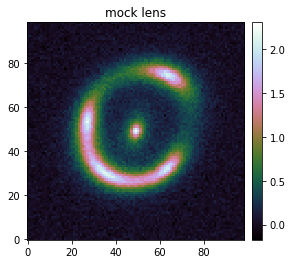

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("mock lens")
im = plt.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

## Setup sparse optimizazion

In [8]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': n_scales_source, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': n_scales_lens_light, 'n_pixels': np.size(image_sim)}  # add center_x/center_y
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'initial_guess_type': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    #'num_iter': 100,  # when only source
    'num_iter_source': 100,
    'num_iter_lens': 100,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

## Timings of current implementation

In [9]:
# we can isolate the solver object
solver = imageSparseFit.sparseSolver

### Compute lensing operator

In [10]:
# update manually the lensing operator
start = time.time()
solver.lensingOperator.update_mapping(kwargs_lens)
end = time.time()
print("Lensing operator building took {:e} s".format(end - start))

# Note that this operation can hardly be cast in `tensforflow` but who knows?

Lensing operator building took 5.371593e+00 s


In [11]:
# some random source and (convolved) lens light estimates
S = np.random.rand(num_pix * subgrid_res_source, num_pix * subgrid_res_source)
HG = np.random.rand(num_pix, num_pix)

### Call to the loss function

In [12]:
# start = time.time()
# loss = solver.loss(S=S, HG=HG)
# end = time.time()
# print("Single call to loss function took {:e} s".format(end-start))
print("Calling the loss function")
%timeit solver.loss(S=S, HG=HG)

Calling the loss function
1.64 ms ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Call to the gradient

In [13]:
# start = time.time()
# loss = solver.gradient_loss_source(S)
# end = time.time()
# print("Single call to loss gradient (wrt source) took {:e} s".format(end-start))
print("Calling grad(loss) wrt source")
%timeit solver.gradient_loss_source(S)

# start = time.time()
# loss = solver.gradient_loss_lens(HG)
# end = time.time()
# print("Single call to loss gradient (wrt lens) took {:e} s".format(end-start))
print("\nCalling grad(loss) wrt lens")
%timeit solver.gradient_loss_lens(HG)

Calling grad(loss) wrt source
926 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Calling grad(loss) wrt lens
8.96 µs ± 76.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Comparison with `TensorFlow`'s auto-differentiation

In [14]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [17]:
def tf_gradient_loss_source(S):
    
    def F(array):
        # Do lensing
        source_1d = array.flatten()
        image = solver._lensing_op._source2image_matrix(source_1d)
        return np.reshape(image, array.shape)
#         return solver._lensing_op.source2image_2d(array)
    
    def H(array):
        # Do 2D convolution with PSF kernel
        return solver._conv.convolution2d(array)
    
    def model_analysis(S):
        return H(F(S))
    
    def H_T(array):
        if solver._conv_transpose is None:
            return array
        # Do 2D convolution with transposed PSF kernel
        # tf.nn.convolution...
        return solver._conv_transpose.convolution2d(array)
    
    def F_T(array):
        # Do ray-tracing
        # Replace solver._lensing_op.image2source_2d()
        
        return solver._lensing_op.image2source_2d(array)
    
#     model = tf.convert_to_tensor(solver.model_analysis(S, HG=None))
    model = tf.convert_to_tensor(model_analysis(S))
    error = tf.convert_to_tensor(solver.Y_eff) - model
    return -F_T(H_T(error))

print(type(tf_gradient_loss_source(S)))
np.array_equal(solver.gradient_loss_source(S), tf_gradient_loss_source(S))

ValueError: cannot reshape array of size 9801 into shape (198,198)

In [15]:
solver._lensing_op._lens_mapping_matrix.shape

(9801, 39204)

In [16]:
solver._lensing_op._matrix_prod

True

In [16]:
%timeit tf_gradient_loss_source(S)

1.02 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
np.array_equal(solver._conv_transpose._kernel, psf_kernel)

True

In [48]:
from scipy import sparse

In [25]:
# def find_source_pixel(i, beta_x, beta_y, grid_offset_x=0, grid_offset_y=0):
#     dist2_map = distance_to_source_grid(i, beta_x, beta_y, grid_offset_x, grid_offset_y, squared=True)
#     # find the index that corresponds to the minimal distance (closest pixel)
#     j = np.argmin(dist2_map)
#     return j

# def distance_to_source_grid(i, beta_x, beta_y, grid_offset_x=0, grid_offset_y=0, 
#                             squared=False, pixel_conversion=False):
#     diff_x, diff_y = difference_on_source_grid_axis(i, beta_x, beta_y, grid_offset_x, 
#                                                     grid_offset_y, pixel_conversion)
#     if squared:
#         return diff_x**2 + diff_y**2
#     return np.hypot(diff_x, diff_y)

# def difference_on_source_grid_axis(i, beta_x_image, beta_y_image, grid_offset_x=0, grid_offset_y=0,
#                                    absolute=False, pixel_conversion=False):
#     return solver._lensing_op._difference_on_source_grid_axis(i, beta_x_image, beta_y_image, 
#                                                               grid_offset_x, grid_offset_y,
#                                                               absolute, pixel_conversion)

# def tf_lens_mapping(lensModel, kwargs_lens, imagePlane, sourcePlane):
#     lensing_matrix = np.zeros((imagePlane.grid_size, sourcePlane.grid_size))
#     beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
#     grid_offset_x, grid_offset_y = (0, 0)
#     for ii in range(imagePlane.grid_size):
#         # Keep old way for now
#         jj = find_source_pixel(ii, beta_x, beta_y, grid_offset_x, grid_offset_y)
#         lensing_matrix[ii, jj] = 1
#     return lensing_matrix

## Tensorflow F

In [119]:
def find_surrounding_source_pixels(sourcePlane, i, beta_x, beta_y, grid_offset_x=0, grid_offset_y=0, 
                                   sort_distance=True):
    # map of the distance to the ray-traced pixel, along each axis, in pixel units
    diff_map_x_pix, diff_map_y_pix = difference_on_source_grid_axis(sourcePlane, i, beta_x, beta_y, 
                                                                    grid_offset_x, grid_offset_y, 
                                                                    pixel_conversion=True)

    # index of source pixel that is the closest to the ray-traced pixel
    j = np.argmin(diff_map_x_pix**2 + diff_map_y_pix**2)

    # find the 4 neighboring pixels
    nb_list, nb_list_2d, idx_closest = neighboring_pixels(sourcePlane, j, diff_map_x_pix, diff_map_y_pix)

    # compute distance (in pixel units) to lower-left "A" neighboring pixel
    dist_to_A_x, dist_to_A_y = distance_lower_left_neighbor(sourcePlane, i, beta_x, beta_y, nb_list, 
                                                            pixel_conversion=True)

    return nb_list, idx_closest, dist_to_A_x, dist_to_A_y
    
def difference_on_source_grid_axis(sourcePlane, i, beta_x_image, beta_y_image, 
                                   grid_offset_x=0, grid_offset_y=0,
                                   absolute=False, pixel_conversion=False):
    # coordinate grid of source plane
    theta_x_source = sourcePlane.theta_x + grid_offset_x
    theta_y_source = sourcePlane.theta_y + grid_offset_y
    if pixel_conversion:
        num_pix = sourcePlane.num_pix
        delta_pix = sourcePlane.delta_pix
        theta_x_source = (theta_x_source + delta_pix*num_pix/2.) / delta_pix
        theta_y_source = (theta_y_source + delta_pix*num_pix/2.) / delta_pix
        beta_x_image_i = (beta_x_image[i] + delta_pix*num_pix/2.) / delta_pix
        beta_y_image_i = (beta_y_image[i] + delta_pix*num_pix/2.) / delta_pix
    else:
        beta_x_image_i = beta_x_image[i]
        beta_y_image_i = beta_y_image[i]
    # compute the difference between ray-traced coordinate and source plane grid
    dist_x = beta_x_image_i - theta_x_source
    dist_y = beta_y_image_i - theta_y_source
    if absolute:
        return np.abs(dist_x), np.abs(dist_y)
    return dist_x, dist_y
    
def neighboring_pixels(sourcePlane, j, difference_x, difference_y):
    """
    returns the 4 surrounding pixels in the following order [A, B, C, D]
      C:(0, 1) .____. D:(1, 1)
               | o  |
               |    |
      A:(0, 0) '----' B:(1, 0)

    difference_x, difference_y should be in *pixel units*
    """
    diff_x_j, diff_y_j = difference_x[j], difference_y[j]
    # convert to 2D indices
    r, s = index_1d_to_2d_source(sourcePlane, j)
    if diff_x_j >= 0 and diff_y_j >= 0:
        # closest pixel is A (if the pixel distance to grid is defined as "pixel - coordinates")
        nb_list_2d = [(r, s), (r, s+1), (r+1, s), (r+1, s+1)]
        idx_closest = 0
    elif diff_x_j < 0 and diff_y_j >= 0:
        # closest pixel is B
        nb_list_2d = [(r, s-1), (r, s), (r+1, s-1), (r+1, s)]
        idx_closest = 1
    elif diff_x_j >= 0 and diff_y_j < 0:
        # closest pixel is C
        nb_list_2d = [(r-1, s), (r-1, s+1), (r, s), (r, s+1)]
        idx_closest = 2
    elif diff_x_j < 0 and diff_y_j < 0:
        # closest pixel is D
        nb_list_2d = [(r-1, s-1), (r-1, s), (r, s-1), (r, s)]
        idx_closest = 3
    else:
        raise ValueError("Could not find 4 neighboring pixels for pixel {} ({},{})".format(j, r, s))
    # check if indices are not outside of of the image, put None if it is
    max_index_value = sourcePlane.num_pix - 1
    for idx, (r, s) in enumerate(nb_list_2d):
        if r >= max_index_value or s >= max_index_value:
            nb_list_2d[idx] = (None, None)
    # convert indices to 1D index
    nb_list = [index_2d_to_1d_source(sourcePlane, r, s) for (r, s) in nb_list_2d]
    return nb_list, nb_list_2d, idx_closest

def index_1d_to_2d_source(sourcePlane, j):
    if j is None:
        return (None, None)
    x = int(j / sourcePlane.num_pix)
    y = int(j % sourcePlane.num_pix)
    return (x, y)

def index_2d_to_1d_source(sourcePlane, x, y):
    if x is None or y is None:
        return None
    return y + x * sourcePlane.num_pix
    
def distance_lower_left_neighbor(sourcePlane, i, beta_x, beta_y, neighbor_list, pixel_conversion=False):
    nb_idx_A = 0  # following conventions of neighboring_pixels()
    i_A = neighbor_list[nb_idx_A]
    dist_to_A_x = abs(sourcePlane.theta_x[i_A] - beta_x[i])
    dist_to_A_y = abs(sourcePlane.theta_y[i_A] - beta_y[i])
    if pixel_conversion:
        dist_to_A_x /= sourcePlane.delta_pix
        dist_to_A_y /= sourcePlane.delta_pix
    return dist_to_A_x, dist_to_A_y

def bilinear_weights(distance_to_A_x, distance_to_A_y):
    """
    returns bilinear weights following order defined in neighboring_pixels()
    similar to Eq. (B2) of Treu & Koopmans 2004
    """
    t, u = distance_to_A_x, distance_to_A_y
    wA = (1. - t) * (1. - u)
    wB = t * (1. - u)
    wC = (1. - t) * u
    wD = t * u
    return [wA, wB, wC, wD]

def check_inside_grid(pixel_list, weight_list):
    """Remove from pixel and weights list."""
    pixel_list_clean, weight_list_clean = [], []
    for p, w in zip(pixel_list, weight_list):
        if p is not None:
            pixel_list_clean.append(p)
            weight_list_clean.append(w)
    return pixel_list_clean, weight_list_clean

def lens_mapping_interpol(lensModel, kwargs_lens, imagePlane, sourcePlane):
    lensing_matrix = np.zeros((imagePlane.grid_size, sourcePlane.grid_size))
    beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
    grid_offset_x, grid_offset_y = (0, 0)
    for ii in range(imagePlane.grid_size):
        jj, _, dist_A_x, dist_A_y = find_surrounding_source_pixels(sourcePlane, ii, beta_x, beta_y, 
                                                                   grid_offset_x, grid_offset_y)
        weight_list = bilinear_weights(dist_A_x, dist_A_y)
        jj, weight_list = check_inside_grid(jj, weight_list)
        lensing_matrix[ii, jj] = weight_list
    return lensing_matrix

In [127]:
imagePlane = solver._lensing_op.imagePlane
sourcePlane = solver._lensing_op.sourcePlane
lensing_matrix = lens_mapping_interpol(lens_model_class, kwargs_lens, imagePlane, sourcePlane)
print(lensing_matrix.shape)

# Cast lensing_matrix as a sparse tensor
# x_inds, y_inds = np.nonzero(lensing_matrix)
# values = lensing_matrix[lensing_matrix != 0]
# lensing_matrix_sparse = tf.sparse.SparseTensor(indices=list(zip(x_inds, y_inds)), 
#                                                values=values, dense_shape=list(lensing_matrix.shape))
lensing_matrix_sparse = tf.sparse.from_dense(lensing_matrix)

def tf_F(lensing_matrix, source_2d):
#     image_1d = lensing_matrix.dot(source_2d.flat)
#     image_1d = tf.tensordot(lensing_matrix, tf.reshape(source_2d, [source_2d.size]), axes=1)
    image_1d = tf.matmul(lensing_matrix, tf.reshape(source_2d, [source_2d.size, 1]), a_is_sparse=True)
    image_npix = int(np.sqrt(lensing_matrix.shape[0]))
    return tf.reshape(image_1d, [image_npix, image_npix])

def tf_F_sparse(lensing_matrix_sparse, source_2d):
    image_1d = tf.sparse.sparse_dense_matmul(lensing_matrix_sparse, tf.reshape(source_2d, [source_2d.size, 1]))
    image_npix = int(np.sqrt(lensing_matrix.shape[0]))
    return tf.reshape(image_1d, [image_npix, image_npix])

test1 = tf.tensordot(lensing_matrix, tf.reshape(S, [S.size]), axes=1)
test2 = sparse.csr_matrix(lensing_matrix).dot(S.flat)
print(np.allclose(test1, test2))

print(np.allclose(tf_F(lensing_matrix, S), solver.F(S)))
print(np.allclose(tf_F_sparse(lensing_matrix_sparse, S), solver.F(S)))

(9801, 39204)
True
True
True


In [130]:
%timeit solver.F(S)

50.2 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [117]:
%timeit tf_F(lensing_matrix, S)

158 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
%timeit tf_F_sparse(lensing_matrix_sparse, S)

201 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [137]:
def to_sparse(array, use_tf=False):
    if use_tf:
        return tf.sparse.from_dense(array)
    x_inds, y_inds = np.nonzero(array)
    values = array[array != 0]
    array_sparse = tf.sparse.SparseTensor(indices=list(zip(x_inds, y_inds)), 
                                          values=values, dense_shape=list(array.shape))
    return array_sparse

In [138]:
%timeit to_sparse(lensing_matrix, use_tf=True)

427 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Tensorflow H

In [149]:
from scipy import signal
from lenstronomy.ImSim.Numerics.convolution import PixelKernelConvolution

In [150]:
solver._conv_transpose._type

'fft_static'

In [151]:
pkc = PixelKernelConvolution(psf_kernel, convolution_type='fft_static')
# pkc = pkc.copy_transpose()

In [26]:
pkc.convolution2d(S).shape

(198, 198)

In [183]:
def H(psf_kernel, image):
    # Do 2D convolution with PSF kernel
    pkc = PixelKernelConvolution(psf_kernel, convolution_type='fft_static')
    return pkc.convolution2d(image)
    
def tf_H(psf_kernel, image):
#     return image
    nx_img, ny_img = image.shape
    nx_psf, ny_psf = psf_kernel.shape
    result = tf.nn.conv2d(tf.reshape(image, [1, nx_img, ny_img, 1]), 
                          tf.reshape(psf_kernel, [nx_psf, ny_psf, 1, 1]),
                          strides=1, padding='SAME')
    return tf.squeeze(result)
    
def tf_model_analysis(lensing_matrix, psf_kernel, source_2d, sparse=True):
    if sparse:
        image_2d = tf_F_sparse(lensing_matrix, source_2d)
    else:
        image_2d = tf_F(lensing_matrix, source_2d)
        
    return tf_H(psf_kernel, image_2d.numpy())

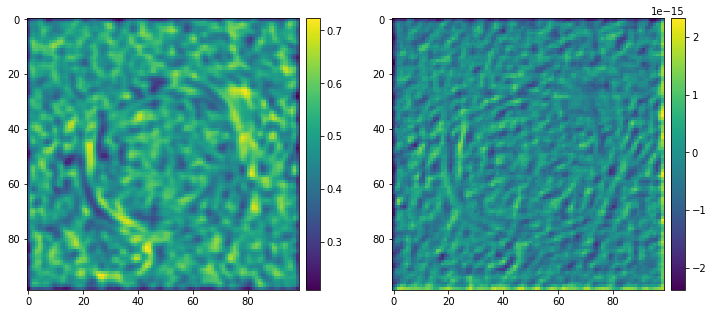

In [186]:
my_model = tf_model_analysis(lensing_matrix_sparse, psf_kernel, S, sparse=True)
model = solver.model_analysis(S)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
img1 = ax1.imshow(my_model)
img2 = ax2.imshow(model - my_model)
nice_colorbar(img1)
nice_colorbar(img2)

In [189]:
img = solver.F(S)

In [190]:
%timeit solver.H(img)

387 µs ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [192]:
%timeit tf_H(psf_kernel, img)

5.71 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [195]:
type(tf_H(psf_kernel, img))
type(solver.H(img))

numpy.ndarray

In [196]:
type(lensing_matrix_sparse) 

tensorflow.python.framework.sparse_tensor.SparseTensor